# Walkability analysis demo

This notebook demonstrates loading the provided `data/roads.gpkg` and `data/cadastre.gpkg`, computing simple walkability metrics using the `src.walkability` helpers, plotting the layers, and printing a combined walkability score.

In [55]:
# Cell 1: imports and repo-root setup
import sys
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt

# Determine repository root so `src` can be imported when the notebook
root = Path('..').resolve() if Path.cwd().name == 'notebooks' else Path('.').resolve()
sys.path.insert(0, str(root))

from src.walkability import load_gpkg, compute_road_length_density, compute_intersection_density, compute_parcel_density, compute_walkability_score

In [56]:
# Cell 2: load data
data_dir = root / 'data'
roads_fp = data_dir / 'roads.gpkg'
cad_fp = data_dir / 'cadastre.gpkg'

print('roads file exists:', roads_fp.exists())
print('cadastre file exists:', cad_fp.exists())

# load (the helper wraps geopandas read_file)
roads = load_gpkg(str(roads_fp))
cad = load_gpkg(str(cad_fp))

# show a couple rows (renders in notebook)
roads.head()
cad.head()

roads file exists: True
cadastre file exists: True


,state,sa4,geometry
0,NSW,Sydney - North Sydney and Hornsby,"MULTIPOLYGON (((151.21055 -33.7947, 151.21112 ..."
1,NSW,Sydney - North Sydney and Hornsby,"MULTIPOLYGON (((151.21074 -33.79414, 151.21102..."
2,NSW,Sydney - North Sydney and Hornsby,"MULTIPOLYGON (((151.21103 -33.79528, 151.21169..."
3,NSW,Sydney - North Sydney and Hornsby,"MULTIPOLYGON (((151.21126 -33.79559, 151.21139..."
4,NSW,Sydney - North Sydney and Hornsby,"MULTIPOLYGON (((151.21182 -33.79607, 151.21182..."


In [57]:
# Cell 3: ensure projected CRS (meters)
def ensure_projected(gdf):
    if gdf is None or gdf.empty:
        return gdf
    if gdf.crs is None:
        return gdf
    if getattr(gdf.crs, 'is_geographic', False):
        return gdf.to_crs(epsg=3857)
    return gdf

roads = ensure_projected(roads)
cad = ensure_projected(cad)

print('roads crs:', getattr(roads, 'crs', None))
print('cad crs:', getattr(cad, 'crs', None))

roads crs: EPSG:3857
cad crs: EPSG:3857


In [58]:
# Cell 4: compute metrics
rd = compute_road_length_density(roads)
idens = compute_intersection_density(roads)
pd = compute_parcel_density(cad)

print(f'Road length density (km / km^2): {rd:.3f}')
print(f'Intersection density (count / km^2): {idens:.3f}')
print(f'Parcel density (count / km^2): {pd:.3f}')

Road length density (km / km^2): 7.997
Intersection density (count / km^2): 75.681
Parcel density (count / km^2): 241.606


In [59]:
# Cell 5: compute overall walkability score
score = compute_walkability_score(roads, cad)
print(f'Walkability score (0-100): {score:.2f}')

Walkability score (0-100): 79.94


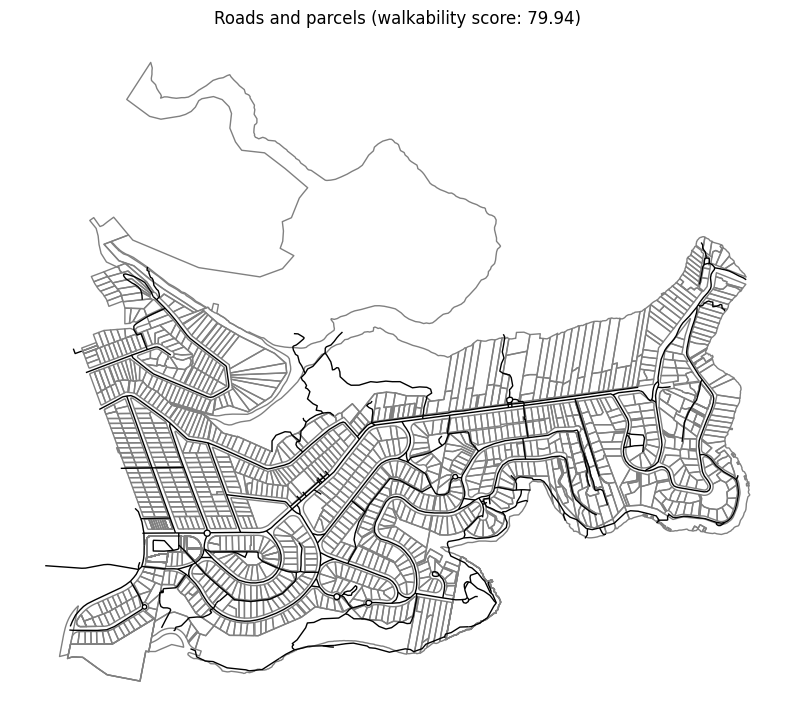

In [60]:
# Cell 6: quick plot (roads over parcels)
%matplotlib inline
ax = cad.plot(facecolor='none', edgecolor='gray', figsize=(10, 10))
roads.plot(ax=ax, linewidth=1, color='black')
ax.set_title(f'Roads and parcels (walkability score: {score:.2f})')
plt.axis('off')
plt.show()

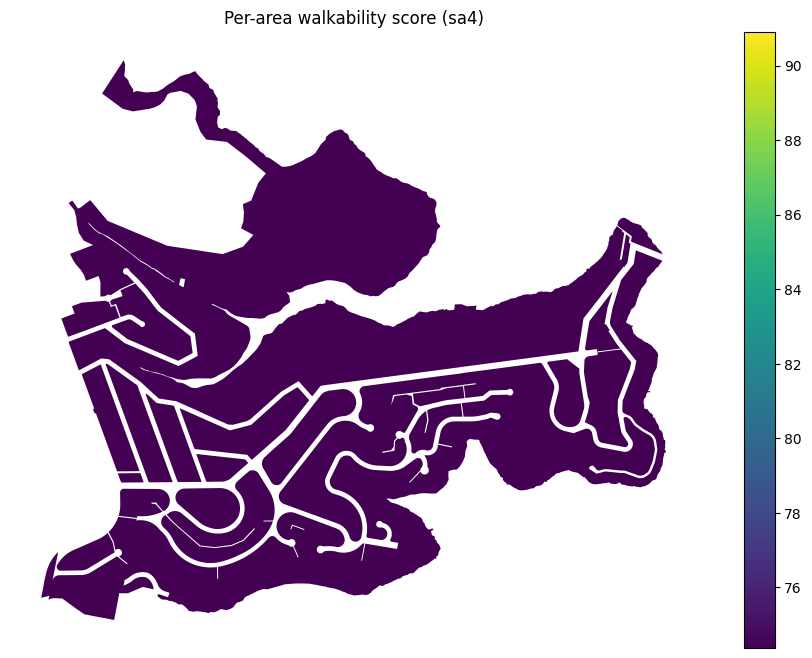

In [61]:
# Cell 7: per-area (sa4) aggregation and choropleth
import pandas as pd
out_fp = root / 'outputs' / 'per_area_scores_sa4.csv'
if out_fp.exists():
    df = pd.read_csv(out_fp)
    # dissolve cadastre to area polygons by sa4 and merge scores\n
    if 'sa4' not in cad.columns:
        print('`sa4` field not found in cadastre; available columns:', cad.columns)
    else:
        areas = cad.dissolve(by='sa4', as_index=False)
        areas = areas.merge(df, on='sa4', how='left')
        areas = ensure_projected(areas)
        ax = areas.plot(column='score', cmap='viridis', legend=True, figsize=(12, 8), missing_kwds={'color': 'black'})
        ax.set_title('Per-area walkability score (sa4)')
        plt.axis('off')
        plt.show()
else:
    print('Outputs CSV not found. Run scripts/per_area_scores.py to generate outputs.')

Loaded scores rows: 9
No official SA4 file found in data/; falling back to convex-hull+buffer polygons from G-NAF points.
If you want the official ABS SA4 shapefile, download it and place it in data/ as one of:
  - sa4_official.gpkg
  - SA4_2021_AUST_GDA2020.gpkg
  - SA4_2021_AUST_GDA2020.shp
No official SA4 file found in data/; falling back to convex-hull+buffer polygons from G-NAF points.
If you want the official ABS SA4 shapefile, download it and place it in data/ as one of:
  - sa4_official.gpkg
  - SA4_2021_AUST_GDA2020.gpkg
  - SA4_2021_AUST_GDA2020.shp


/tmp/ipykernel_12304/2743133535.py:89: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  u = gs.unary_union


Saved per-locality map to /home/jordan/microburbs_assessment/outputs/plots/per_locality_map.png


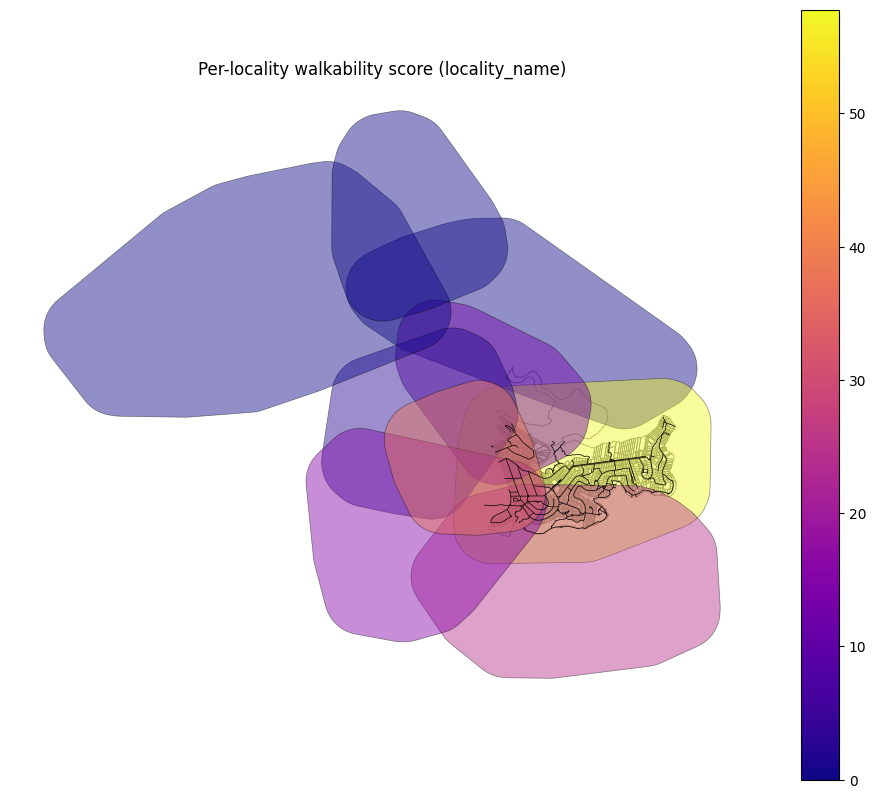

In [62]:
# Cell 8: per-locality choropleth reconstructed from G-NAF points + scores
import pandas as pd
from shapely import wkb
import geopandas as gpd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from pathlib import Path

scores_fp = root / 'outputs' / 'per_locality_scores_locality_name.csv'
gnaf_fp = root / 'data' / 'gnaf_prop.parquet'
# candidate paths for an official SA4 / region boundary file (user can place one of these in data/)
official_candidates = [
    root / 'data' / 'sa4_official.gpkg',
    root / 'data' / 'SA4_2021_AUST_GDA2020.gpkg',
    root / 'data' / 'SA4_2021_AUST_GDA2020.shp',
    root / 'data' / 'sa4_aust_2021.gpkg'
]

# Helper to try to load an official SA4 dataset and filter to the named region
def load_official_sa4(name='Sydney - North Sydney and Hornsby'):
    for p in official_candidates:
        if p.exists():
            try:
                g = gpd.read_file(str(p))
                # try couple common name fields
                name_fields = ['SA4_NAME21','sa4_name','NAME','name','sa4_name21']
                for f in name_fields:
                    if f in g.columns:
                        sel = g[g[f].str.contains(name, case=False, na=False)]
                        if len(sel):
                            return sel
                # fallback: return whole dataset so caller can spatially intersect
                return g
            except Exception as e:
                print('Failed to read candidate', p, '->', e)
    return None

# Attempt to load scores + G-NAF
if scores_fp.exists() and gnaf_fp.exists():
    scores = pd.read_csv(scores_fp)
    print('Loaded scores rows:', len(scores))

    # read G-NAF points (WKB hex in `geom` column) into GeoDataFrame
    table = pq.read_table(str(gnaf_fp))
    gnaf_df = table.to_pandas()
    geom = gnaf_df['geom'].apply(lambda s: wkb.loads(bytes.fromhex(s)) if pd.notna(s) else None)
    gnaf_gdf = gpd.GeoDataFrame(gnaf_df, geometry=geom, crs='EPSG:4326')

    # Keep only localities present in the scores to speed up processing
    keep = scores['locality_name'].unique()
    gnaf_gdf = gnaf_gdf[gnaf_gdf['locality_name'].isin(keep)]

    # project to metric CRS for buffering and plotting
    gnaf_gdf = ensure_projected(gnaf_gdf)
    roads_p = ensure_projected(roads)
    cad_p = ensure_projected(cad)

    # Try to load an official SA4 boundary for the named SA4
    official_sa4 = load_official_sa4('Sydney - North Sydney and Hornsby')
    if official_sa4 is not None:
        print('Using official SA4 boundary from data/ (first match).')
        official_sa4 = ensure_projected(gpd.GeoDataFrame(official_sa4))
    else:
        print('No official SA4 file found in data/; falling back to convex-hull+buffer polygons from G-NAF points.\n'
              'If you want the official ABS SA4 shapefile, download it and place it in data/ as one of:\n  - sa4_official.gpkg\n  - SA4_2021_AUST_GDA2020.gpkg\n  - SA4_2021_AUST_GDA2020.shp')

    # build locality polygons: prefer official boundary subset if available and intersects locality points
    if official_sa4 is not None:
        # If official boundaries are available, intersect points to find which polygon matches each locality
        # We'll attempt a spatial join: each point -> polygon, then aggregate polygons per locality_name
        try:
            join = gpd.sjoin(gnaf_gdf, official_sa4[['geometry']], how='left', predicate='within')
            # if join produced an index_right use it; otherwise fall back
            if 'index_right' in join.columns:
                # Map points back to polygons and aggregate by locality_name
                polys = join.groupby('locality_name')['index_right'].unique().apply(lambda ids: official_sa4.loc[list(ids)].unary_union if len(ids) else None)
                areas_ser = polys.reset_index(name='geometry')
                areas = gpd.GeoDataFrame(areas_ser, geometry='geometry', crs=official_sa4.crs)
            else:
                raise RuntimeError('Spatial join did not produce index_right')
        except Exception as e:
            print('Official SA4 approach failed, falling back to convex-hull buffer. Reason:', e)
            official_sa4 = None

    if official_sa4 is None:
        # fallback: convex hull + 500m buffer per locality
        def locality_geom(gs):
            try:
                u = gs.unary_union
                return u.convex_hull.buffer(500)
            except Exception:
                return None
        areas_ser = gnaf_gdf.groupby('locality_name')['geometry'].apply(locality_geom).reset_index(name='geometry')
        areas = gpd.GeoDataFrame(areas_ser, geometry='geometry', crs=gnaf_gdf.crs)

    # merge scores
    areas = areas.merge(scores, on='locality_name', how='left')
    areas = ensure_projected(areas)
    areas = areas[areas.geometry.notna()]

    # Plot strategy implementing A, C, D:
    # A) draw outlines for non-highlight layers (cadastre or official SA4) so map is not overfilled
    # C) apply a distinct colormap and a moderate alpha
    # D) if roads have a classification field, draw major roads thicker and in a different color

    # Prepare roads style mapping (attempt to detect classification fields)
    road_class_field = None
    candidates = ['road_type','type','fclass','class','rclass','roadclass','FUNC_CLASS']
    for c in candidates:
        if c in roads_p.columns:
            road_class_field = c
            break

    # If we have a class field, create a simple style mapping
    road_styles = None
    if road_class_field is not None:
        vals = list(roads_p[road_class_field].dropna().unique())
        # sort values so we map consistently (major->minor based on string length heuristic or known keywords)
        vals_sorted = sorted(vals, key=lambda s: (0 if str(s).lower() in ('motorway','primary','major','arterial','trunk') else 1, str(s)))
        # assign linewidths and colors
        colors = ['#000000','#333333','#666666','#999999']
        lws = [1.6, 1.2, 0.8, 0.5]
        road_styles = {v: {'color': colors[i % len(colors)], 'linewidth': lws[i % len(lws)]} for i,v in enumerate(vals_sorted)}

    # ensure outputs directory exists
    out_plot_dir = root / 'outputs' / 'plots'
    out_plot_dir.mkdir(parents=True, exist_ok=True)

    fig, ax = plt.subplots(figsize=(12, 10))

    # 1) background roads (light gray) - full network
    try:
        roads_p.plot(ax=ax, color='lightgray', linewidth=0.5, zorder=1)
    except Exception:
        roads_p = roads.to_crs(areas.crs)
        roads_p.plot(ax=ax, color='lightgray', linewidth=0.5, zorder=1)

    # 2) cadastre or official SA4 outlines only (no fill) so map remains readable (A)
    try:
        if official_sa4 is not None:
            # draw the whole SA4 layer outlines
            official_sa4.boundary.plot(ax=ax, color='gray', linewidth=0.6, zorder=2)
        else:
            cad_p.boundary.plot(ax=ax, color='gray', linewidth=0.6, zorder=2)
    except Exception:
        # fallback to dissolved cadastre if boundary fails
        cad_outline = cad_p.dissolve().boundary
        cad_outline.plot(ax=ax, color='gray', linewidth=0.6, zorder=2)

    # 3) colored locality polygons for those with scores (C)
    # choose colormap and alpha
    cmap = 'plasma'
    alpha = 0.45
    # only plot those with non-null score as filled polygons
    filled = areas[areas['score'].notna()]
    empty = areas[areas['score'].isna()]

    if not filled.empty:
        filled.plot(column='score', ax=ax, cmap=cmap, alpha=alpha, legend=True, zorder=3, edgecolor='black', linewidth=0.5)
    # outline the empty/other areas but don't fill
    if not empty.empty:
        empty.boundary.plot(ax=ax, color='black', linewidth=0.4, linestyle='--', zorder=3)

    # 4) overlay roads again, trying to differentiate classes if possible (D)
    if road_styles is not None:
        for val, style in road_styles.items():
            subset = roads_p[roads_p[road_class_field] == val]
            if len(subset):
                subset.plot(ax=ax, color=style['color'], linewidth=style['linewidth'], zorder=4)
        # draw any roads without class as thin black
        others = roads_p[roads_p[road_class_field].isna()]
        if len(others):
            others.plot(ax=ax, color='black', linewidth=0.5, zorder=4)
    else:
        # no classification field found - simple crisp overlay
        roads_p.plot(ax=ax, color='black', linewidth=0.6, zorder=4)

    ax.set_title('Per-locality walkability score (locality_name)')
    plt.axis('off')

    # save a copy
    out_fp = out_plot_dir / 'per_locality_map.png'
    plt.savefig(out_fp, dpi=200, bbox_inches='tight')
    print('Saved per-locality map to', out_fp)
    plt.show()
else:
    print('Per-locality scores CSV or G-NAF parquet not found. Run scripts/per_locality_scores.py first.')


## Next steps
- Use the notebook to explore per-suburb or gridded scores.
- Add amenity/transit layers and distance-based metrics.
- Replace naive intersection detection with a spatial-indexed node extraction for large networks.